# DeepFake Video Detection

## Packages and Parameters

In [86]:
# Load packages

import os
from os import path
from typing import Optional
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm
import time
import math

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torchinfo
import cv2 as cv

import matplotlib.pyplot as plt

In [87]:
# Parameters

MY_NAME_IS = 'Nitzan'

TRAIN_PARTS = [0, 1, 2, 3]
TEST_PARTS = [4]

DOWN_FPS = 10
FRAME_SCALE = 20
GRAYCOLOR = False

BATCH_SIZE = 3
EPOCH_NUM = 1

################################################################################################

DATA_FOLDER_DICT = {
    'Victor': ['E:\DeepFakeDetection\dfdc_train_all','E:\DeepFakeDetection\smalldata'],
    'Nitzan': ['D:\dfdc','D:\dfdc_small5'],
    'Netanel':['F:\input','F:\input']}
BIG_DATA_FOLDER = DATA_FOLDER_DICT[MY_NAME_IS][0]
SMALL_DATA_FOLDER = DATA_FOLDER_DICT[MY_NAME_IS][1]

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The chosen device: {TORCH_DEVICE}')

SMALLFILE_EXT = 'tns'

The chosen device: cuda


## Data Analysing and Preproccesing

In [88]:
# Load and concat all JSON files

meta_df = pd.DataFrame()
metadata_glob = glob.iglob('**/metadata.json', recursive=True, root_dir=BIG_DATA_FOLDER)
ii = 0
for metadata in metadata_glob:
    metadata_path = path.join(BIG_DATA_FOLDER, metadata)
    dir_path = os.path.dirname(os.path.realpath(metadata_path))
    part_df = pd.read_json(metadata_path).T
    part_df['part'] = ii
    part_df['bigdata_path'] = dir_path
    part_df['smalldata_path'] = f"{SMALL_DATA_FOLDER}\{ii}"
    #part_df['filename'] = part_df.index
    meta_df = pd.concat([meta_df, part_df])
    ii += 1

display(meta_df)

,label,split,original,part,bigdata_path,smalldata_path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
vpmyeepbep.mp4,REAL,train,NaN,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
fzvpbrzssi.mp4,REAL,train,NaN,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
...,...,...,...,...,...,...
ltiekbqamw.mp4,FAKE,train,icffpvvtnu.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small5\49
qxkhbvpomm.mp4,FAKE,train,icffpvvtnu.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small5\49
yxgljheoyy.mp4,FAKE,train,rzytdiivhu.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small5\49
wadgdooqpl.mp4,FAKE,train,mhpavogfxb.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small5\49


<Axes: title={'center': 'Histogram of Classes / Labels'}, xlabel='Class', ylabel='Count'>

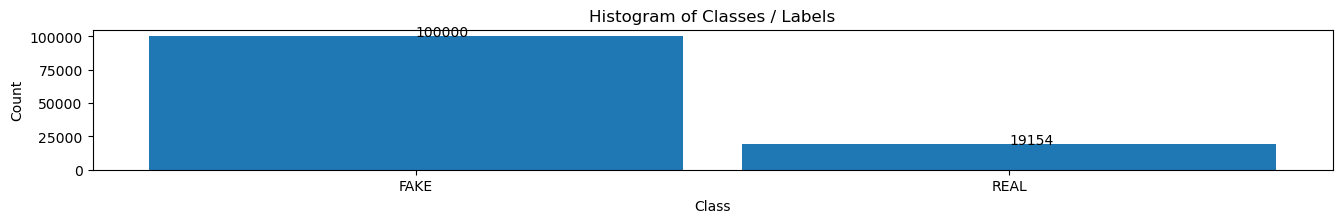

In [89]:
# Histogram

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def PlotLabelsHistogram(vY: np.ndarray, labels_list, hA: Optional[plt.Axes] = None ) -> plt.Axes:
    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    vLabels, vCounts = np.unique(vY, return_counts = True)
    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    addlabels(vLabels, vCounts)
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_xticks(vLabels, labels_list)
    hA.set_ylabel('Count')
    return hA

plt.figure(figsize=(16, 4))
ax = plt.subplot(2,1,1)
PlotLabelsHistogram(meta_df['label'],meta_df['label'].unique(),ax)

In [90]:
# Split Data, Take part of data

metadata_train_df = meta_df[meta_df['part'].isin(TRAIN_PARTS)].copy()
metadata_test_df = meta_df[meta_df['part'].isin(TEST_PARTS)].copy()
metadata_test_df['split'] = 'test'
metadata_df = pd.concat((metadata_train_df,metadata_test_df))
display(metadata_df)

,label,split,original,part,bigdata_path,smalldata_path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
vpmyeepbep.mp4,REAL,train,NaN,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
fzvpbrzssi.mp4,REAL,train,NaN,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small5\0
...,...,...,...,...,...,...
zgvjfpzubp.mp4,REAL,test,NaN,4,D:\dfdc\dfdc_train_part_12,D:\dfdc_small5\4
pnxmphjyyo.mp4,REAL,test,NaN,4,D:\dfdc\dfdc_train_part_12,D:\dfdc_small5\4
oathlhqdnz.mp4,FAKE,test,wcdmpwfooh.mp4,4,D:\dfdc\dfdc_train_part_12,D:\dfdc_small5\4
oexoavedkb.mp4,FAKE,test,zgvjfpzubp.mp4,4,D:\dfdc\dfdc_train_part_12,D:\dfdc_small5\4


In [111]:
# Load Video: Downgrade video from big data to small

#from moviepy.editor import AudioFileClip

def LoadVideo(filepath,down_fps,scale_fact,isGray):
    video = []
    REF_HEIGHT = 1080
    REF_WIDTH = 1920
    down_height = round(REF_HEIGHT/scale_fact)
    down_width = round(REF_WIDTH/scale_fact)
    down_points = (down_width, down_height)
    cap = cv.VideoCapture(filepath)
    fps = cap.get(cv.CAP_PROP_FPS) 
    fcnt = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    fps_factor = round(fps/down_fps)
    #audio_clip = AudioFileClip(filepath)

    for ii_f in range(int(fcnt/fps_factor)*fps_factor):
        if(cap.isOpened() == False):
            break
        ret, frame = cap.read()
        #sample = audio_clip.get_frame()
        if((ii_f % fps_factor) != 0): # DownFramesPerSecond
            continue
        # if frame is read correctly ret is True
        if not ret:
            break
        
        height, width, channels = frame.shape
        if(height>width):
            frame = cv.rotate(frame, cv.ROTATE_90_CLOCKWISE)

        if(isGray):
            frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2GRAY),down_points,interpolation = cv.INTER_LINEAR)
            if(ii_f==0):
                frame_sample = np.expand_dims(frame_sample,0)
                video = np.resize(frame_sample, (round(fcnt/fps_factor),frame_sample.shape[1],frame_sample.shape[2]))
            video[round(ii_f/fps_factor),:,:] = frame_sample
        else:
            frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2RGB),down_points,interpolation = cv.INTER_LINEAR)
            if(ii_f==0):
                frame_sample = np.expand_dims(frame_sample,0)
                video = np.resize(frame_sample, (round(fcnt/fps_factor),frame_sample.shape[1],frame_sample.shape[2],frame_sample.shape[3]))
            video[round(ii_f/fps_factor),:,:,:] = frame_sample

    cap.release()
    cv.destroyAllWindows()
    video = np.array(video)
    video = torch.tensor(video)
    return video

In [ ]:
# Offline Preprocess
LAST_FILE_IND = 0
    
for ii in tqdm(range(LAST_FILE_IND, metadata_df.shape[0]),desc="Downgrading videos"):
    try:
        bigfilepath = f"{metadata_df['bigdata_path'].iloc[ii]}\{metadata_df.index[ii]}"
        smallfilepath = f"{metadata_df['smalldata_path'].iloc[ii]}\{metadata_df.index[ii]}"
        smallfilepath = f"{smallfilepath[0:-4]}.{SMALLFILE_EXT}"
        video = LoadVideo(bigfilepath,DOWN_FPS,FRAME_SCALE,GRAYCOLOR)
        
        if(os.path.exists(metadata_df['smalldata_path'].iloc[ii])==False):
            os.makedirs(metadata_df['smalldata_path'].iloc[ii])
        torch.save(video,smallfilepath)
    except Exception as e:
        print(f"Error: {e}")
        continue


In [117]:

# New preprocess function. Performs:
# - downscales fps to the given value, 
# - resizes to the given width (preserving aspect ratio)
# - converts to tensor

def preprocess_video(filepath: str, output_fps: int, resize_height: int, crop_size: int):
  cap = cv.VideoCapture(filepath)
  fps = cap.get(cv.CAP_PROP_FPS)
  frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
  fps_step = round(fps / output_fps)

  width: int = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
  height: int = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
  aspect_ratio = width / height
  if (height > width):
    return None

  if not cap.isOpened():
    raise Exception("Error opening video file")
  
  new_width = int(resize_height * aspect_ratio)
  new_height = resize_height
  new_frame_count = frame_count // fps_step

  video = torch.empty((new_frame_count, crop_size, crop_size, 3), dtype=torch.uint8)

  for index in range(new_frame_count * fps_step):
    ok, frame = cap.read()
    if not ok:
      print(index, frame_count, new_frame_count*fps_step)
      raise Exception('Error reading frame')

    if index % fps_step != 0:
      continue
    scaled_index = index // fps_step

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    # Resize frame, video is in HWC format
    frame = cv.resize(frame, (new_height, new_width), interpolation=cv.INTER_AREA)

    # Center crop frame
    x = (new_width - crop_size) // 2
    y = (new_height - crop_size) // 2
    frame = frame[x:x+crop_size, y:y+crop_size, :] 

    video[scaled_index] = torch.tensor(frame, dtype=torch.uint8)

  cap.release()
  return video
  

In [122]:
start_file_index = 0
file_count = metadata_df.shape[0]

output_fps = 10
resize_width = 128
crop_size = 112

pbar = tqdm(
  metadata_df[start_file_index:].iterrows(), 
  total=file_count-start_file_index, 
  desc="Preprocessing videos"
  )

for file_name, row in pbar:
  # try:
  original_file_path = path.join(row['bigdata_path'], file_name)
  base_name, _ = path.splitext(file_name)
  target_file_path = path.join(row['smalldata_path'], f"{base_name}.{SMALLFILE_EXT}")
  
  video = preprocess_video(original_file_path, output_fps, resize_width, crop_size)
  if video is None:
    continue
  # print(video)
  # print(f'video shape: {video.shape}, dtype: {video.dtype}, size in memory: {video.element_size() * video.nelement() / (1024**2):.2f}mb')

  output_dir = row['smalldata_path']
  if not path.exists(output_dir):
    os.makedirs(output_dir)
  torch.save(video, target_file_path)
  # except Exception as e:
  #   print(f"Error: {e}")
  #   continue


Preprocessing videos:   0%|          | 0/10568 [00:00<?, ?it/s]

In [ ]:
# Load Smalldata from files

metadata_df = metadata_train_df[metadata_train_df['part'].isin([1])] # , 2, 5

for ii in tqdm(range(metadata_df.shape[0]),desc="Loading smalldata videos"):
    smallfilepath = f"{metadata_df['smalldata_path'].iloc[ii]}\{metadata_df.index[ii]}"
    smallfilepath = f"{smallfilepath[0:-4]}.{SMALLFILE_EXT}"
    video = torch.load(smallfilepath)
    if(ii==0):
        videos = video.unsqueeze(0).expand(metadata_df.shape[0],-1,-1,-1)
    videos[ii,:,:,:] = video

display(videos.shape)

In [ ]:
metadata_df

In [ ]:
def process_video(video: torch.Tensor) -> torch.Tensor:
  video = torch.narrow(video, 0, 0, 90)
  return video

# Initialize train and validation datasets
# TODO videodataset root paths and transforms - this depends on Victor's offline preprocessing 
metadata_df
train_roots = [path.join(SMALL_DATA_FOLDER, str(i)) for i in TRAIN_PARTS]
train_transform = transforms.Compose([
    transforms.Lambda(process_video)
])

train_ds = VideoTensorDataset(
  original_data_path=BIG_DATA_FOLDER, 
  tensor_data_paths=train_roots, 
  transform=train_transform
)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
'''
from sklearn.metrics import matthews_corrcoef
import torchvision.models.detection.retinanet as retinanet

loss_fn = retinanet.FocalLoss() # TODO
score_fn = matthews_corrcoef(y_true, y_pred)
'''

In [ ]:
from efficientnet_pytorch_3d import EfficientNet3D
import torch

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the model and move it to the appropriate device
model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1).to(device)

from torchsummary import summary
summary(model, input_size=(1, 200, 200, 200))

model = model.cuda()
inputs = torch.randn((1, 1, 200, 200, 200)).cuda()
labels = torch.tensor([0]).cuda()
# test forward
num_classes = 2

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.train()
for epoch in range(2):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    print('[%d] loss: %.3f' % (epoch + 1, loss.item()))

print('Finished Training')